# Deep Agent - Multi-Agent Deep Finance Researcher

Advanced financial research system using LangChain's DeepAgent with context isolation and strategic delegation.

## Overview

This notebook demonstrates:
- **DeepAgent Framework**: LangChain's advanced agent architecture
- **Context Isolation**: Sub-agents with isolated contexts for focused research
- **Strategic Delegation**: Orchestrator coordinates multiple specialist sub-agents
- **RAG + Live Data**: Hybrid search on SEC filings + Yahoo Finance integration
- **File-Based Memory**: Persistent research artifacts and reports

**Key Features:**
1. Orchestrator breaks down complex queries into research tasks
2. Sub-agents conduct focused research with isolated context
3. Think tool for strategic reflection and decision-making
4. Final report synthesis with consolidated citations

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from datetime import datetime
from IPython.display import Image, display

from langchain_google_genai import ChatGoogleGenerativeAI
from deepagents import create_deep_agent
from deepagents.backends.utils import file_data_to_string

from scripts.rag_tools import hybrid_search, live_finance_researcher

## Define Research Tools

We provide two specialized tools for financial research:
1. **hybrid_search**: Search historical SEC filings (10-K, 10-Q)
2. **live_finance_researcher**: Get live stock data from Yahoo Finance
3. **think_tool**: Strategic reflection after each research action

In [4]:
from langchain_core.tools import tool

@tool(parse_docstring=True)
def think_tool(reflection: str) -> str:
    """Tool for strategic reflection on research progress and decision-making.
    
    Use this after each search to analyze results and plan next steps.
    
    When to use:
    - After receiving search results: What key information did I find?
    - Before deciding next steps: Do I have enough to answer comprehensively?
    - When assessing research gaps: What specific information am I still missing?
    
    Args:
        reflection: Detailed reflection on research progress, findings, gaps, and next steps
        
    Returns:
        Confirmation that reflection was recorded
    """
    return f"Reflection recorded: {reflection}"

tools = [hybrid_search, live_finance_researcher, think_tool]

## Define System Prompts

### Research Sub-Agent Instructions
Tactical researcher that conducts focused financial research

In [5]:
RESEARCHER_INSTRUCTIONS = """You are a financial research assistant conducting research on SEC filings and market data. Today's date is {date}.

<Task>
Your job is to gather comprehensive financial information using the available research tools.
You can call these tools in series or in parallel during your research loop.
</Task>

<Available Research Tools>
1. **hybrid_search(query, k)**: Search historical SEC filings (10-K, 10-Q) for financial data
   - Use for: Revenue, profit, expenses, cash flow from past quarters/years
   - Automatically extracts company, year, quarter filters
   
2. **live_finance_researcher(query)**: Get live stock data from Yahoo Finance
   - Use for: Current stock prices, latest news, market sentiment
   - Real-time market information
   
3. **think_tool(reflection)**: Reflect on research progress
   - **CRITICAL: Use after each search to assess results and plan next steps**
</Available Research Tools>

<Instructions>
Think like a financial analyst with limited time:

1. **Read the question carefully** - What specific financial data does the user need?
2. **Start with hybrid_search for historical data** - SEC filings are the primary source
3. **After each search, use think_tool** - Do I have enough? What's missing?
4. **Use live_finance_researcher for current data** - Only when needed
5. **Stop when you can answer confidently** - Don't over-research
</Instructions>

<Hard Limits>
**Tool Call Budgets** (Prevent excessive searching):
- **Simple queries**: Use 2-3 search tool calls maximum
- **Complex queries**: Use up to 5 search tool calls maximum
- **Always stop**: After 5 search tool calls if you cannot find adequate sources

**Stop Immediately When**:
- You can answer the user's question comprehensively
- You have 3+ relevant sources for the question
- Your last 2 searches returned similar information
</Hard Limits>

<Show Your Thinking>
After each search, use think_tool to analyze:
- What key financial data did I find?
- What's still missing?
- Do I have enough to answer comprehensively?
- Should I search more or provide my answer?
</Show Your Thinking>

<Final Response Format>
When providing findings back to the orchestrator:

1. **Structure your response**: Organize with clear headings and detailed financial data
2. **Cite sources inline**: Use [1], [2], [3] format
3. **Include Sources section**: End with ### Sources listing each numbered source

Example:
```
## Apple Q1 2024 Financial Performance

Apple's revenue in Q1 2024 was $119.6 billion, up 2% year-over-year [1]. Net income reached $33.9 billion with earnings per share of $2.18 [1].

### Sources
[1] Apple 10-Q Q1 2024: apple 10-q q1 2024.md, page 25
```

The orchestrator will consolidate citations from all sub-agents.
</Final Response Format>
"""

### Orchestrator Instructions
Strategic coordinator that delegates research tasks

In [6]:
RESEARCH_WORKFLOW_INSTRUCTIONS = """# Financial Research Workflow

Follow this workflow for all financial research requests:

1. **Plan**: Create a todo list with write_todos to break down the research into focused tasks
2. **Save the request**: Use write_file() to save the user's question to `/research_request.md`
3. **Research**: Delegate research tasks to sub-agents using the task() tool
   - ALWAYS use sub-agents for research, never conduct research yourself
4. **Synthesize**: Review all sub-agent findings and consolidate citations
5. **Write Report**: Write comprehensive final report to `/final_report.md`
6. **Verify**: Read `/research_request.md` and confirm you've addressed all aspects

## Research Planning Guidelines
- For simple fact-finding: Use 1 sub-agent
- For comparisons or multi-faceted topics: Delegate to multiple parallel sub-agents
- Each sub-agent researches one specific aspect and returns findings

## Report Writing Guidelines

**For financial comparisons:**
1. Introduction
2. Company A financial overview
3. Company B financial overview
4. Detailed comparison
5. Conclusion

**For financial summaries:**
1. Overview
2. Revenue analysis
3. Profitability metrics
4. Cash flow analysis
5. Key takeaways

**General guidelines:**
- Use clear section headings (## for sections, ### for subsections)
- Write in paragraph form - be comprehensive and detailed
- Include specific numbers, percentages, and financial metrics
- Do NOT use self-referential language ("I found...", "I researched...")

**Citation format:**
- Cite sources inline using [1], [2], [3] format
- Each unique source gets one citation number across ALL findings
- End report with ### Sources section
- Format: [1] Source file: filename.md, page X
"""

SUBAGENT_DELEGATION_INSTRUCTIONS = """# Sub-Agent Research Coordination

Your role is to coordinate financial research by delegating tasks to specialized research sub-agents.

## Delegation Strategy

**DEFAULT: Start with 1 sub-agent** for most queries:
- "What was Amazon's revenue in Q1 2024?" → 1 sub-agent
- "Analyze Apple's profitability in 2024" → 1 sub-agent
- "What is Microsoft's cash flow trend?" → 1 sub-agent

**ONLY parallelize when query EXPLICITLY requires comparison:**
- "Compare Apple vs Microsoft Q1 2024 revenue" → 2 parallel sub-agents
- "Compare FAANG companies profitability in 2024" → 5 parallel sub-agents

## Key Principles
- **Bias towards single sub-agent**: One comprehensive task is more efficient
- **Parallelize only for clear comparisons**: Multiple entities being compared

## Parallel Execution Limits
- Use at most {max_concurrent_research_units} parallel sub-agents per iteration
- Make multiple task() calls in a single response for parallel execution

## Research Limits
- Stop after {max_researcher_iterations} delegation rounds if not enough sources
- Stop when you have sufficient information to answer comprehensively
"""

## Create Research Sub-Agent

In [7]:
# Get current date
current_date = datetime.now().strftime("%Y-%m-%d")

# Create research sub-agent with isolated context
research_sub_agent = {
    "name": "financial-research-agent",
    "description": "Delegate financial research to this sub-agent. Give it one specific research task at a time.",
    "system_prompt": RESEARCHER_INSTRUCTIONS.format(date=current_date),
    "tools": [hybrid_search, live_finance_researcher, think_tool],
}

## Initialize LLM and Create DeepAgent

In [ ]:
# Initialize model
llm = ChatGoogleGenerativeAI(model='gemini-3-flash-preview')

# Limits for sub-agent delegation
max_concurrent_research_units = 3
max_researcher_iterations = 10

# Combine orchestrator instructions
INSTRUCTIONS = (
    RESEARCH_WORKFLOW_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SUBAGENT_DELEGATION_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
    )
)

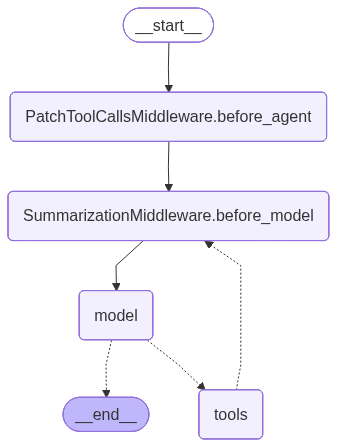

In [9]:
# Create the deep agent
agent = create_deep_agent(
    model=model,
    tools=tools,
    system_prompt=INSTRUCTIONS,
    subagents=[research_sub_agent],
)

# Visualize the agent graph
display(Image(agent.get_graph().draw_mermaid_png()))

## Helper Functions

In [10]:
def format_messages(messages):
    """Format message history for display."""
    for msg in messages:
        role = msg.__class__.__name__
        content = msg.content if hasattr(msg, 'content') else str(msg)
        
        # Truncate long content
        if len(content) > 500:
            content = content[:500] + "..."
        
        print(f"\n{'='*60}")
        print(f"[{role}]")
        print(f"{'='*60}")
        print(content)

def show_report(result):
    """Extract and display the final report."""
    if '/final_report.md' in result['files']:
        report = file_data_to_string(result['files']['/final_report.md'])
        print("\n" + "="*60)
        print("FINAL REPORT")
        print("="*60 + "\n")
        print(report)
    else:
        print("No final report generated")

## Example 1: Simple Financial Query

In [ ]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What was Amazon's revenue in Q1 2024?",
            }
        ],
    },
)

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised NotFound: 404 models/gemini-3-flash-preivew is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 4.0 seconds as it raised NotFound: 404 models/gemini-3-flash-preivew is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods..
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 8.0 seconds as it raised NotFound: 404 models/gemini-3-flash-preivew is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods..
Retrying langchain_google_genai.chat_models

In [ ]:
result

In [ ]:
show_report(result)

## Example 2: Multi-Company Comparison

In [ ]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Compare Apple and Microsoft's Q1 2024 revenue and profitability",
            }
        ],
    },
)

In [ ]:
result

In [ ]:
show_report(result)

## Example 3: Complex Financial Analysis

In [ ]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Analyze Tesla's financial performance in 2023 and 2024, including revenue, profitability, and cash flow trends",
            }
        ],
    },
)

In [ ]:
show_report(result)

## Example 4: Historical + Live Data

In [ ]:
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Research Google's Q2 2024 financial performance from SEC filings and compare it with current stock performance",
            }
        ],
    },
)

In [ ]:
show_report(result)

## Inspect Message History

In [ ]:
format_messages(result['messages'])

## Inspect Generated Files

In [ ]:
# List all files generated
print("Generated Files:")
for file_path in result['files'].keys():
    print(f"  - {file_path}")

In [ ]:
# Read research request
if '/research_request.md' in result['files']:
    request = file_data_to_string(result['files']['/research_request.md'])
    print("Research Request:")
    print(request)